In [1]:
# import packages
import sys
sys.path.insert(0, '../monod/src/')

import numpy as np
import pandas as pd
import pickle
import itertools

import glob
import matplotlib.pyplot as plt
import seaborn as sns

# import Monod
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [19]:
# define colors

c_burstyo = '#54278f' # purple
c_burstyp = '#9e9ac8'
c_consto  = '#a50f15' # red
c_constp = '#fb6a4a'
c_exto = '#31a354' # green
c_extp = '#74c476'
c_delo = '#3182bd' # blue
c_delp = '#6baed6'
c_delso = '#f16913' # pink --- maybe do brown idk
c_delsp = '#d7b5d8'


colors_cb = [c_burstyo,
             c_burstyp,
             c_consto,
             c_constp,
             'lightgray']

colors = [c_burstyo,
#           c_burstyp,
          c_consto,
#           c_constp,
          c_exto,
#           c_extp,
          c_delo,
#           c_delp,
          c_delso,
#           c_delsp,
          'lightgray']

colors_sep = [c_burstyo,
          c_burstyp,
          c_consto,
          c_constp,
          c_exto,
          c_extp,
          c_delo,
          c_delp,
          c_delso,
          c_delsp,
          'lightgray']

In [3]:
def get_AIC_weights(AIC_vals):
    ''' Returns the AIC weights for each model for multiple genes. 
    '''
    
    if type(AIC_vals) != np.ndarray:
        
        AIC_empty = np.zeros((len(AIC_vals), len(AIC_vals[0]) ))
        for i in range((len(AIC_vals))):
            
            AIC_empty[i,:] = AIC_vals[i]
            
        AIC_vals = AIC_empty
    
    min_AIC = AIC_vals.min(0)
    normalization = np.exp(-(AIC_vals - min_AIC) / 2).sum(0)
    w = np.exp(-(AIC_vals - min_AIC) / 2)
    w = np.exp(-(AIC_vals - min_AIC) / 2) / normalization
    
    
    return(w)

def get_AIC_weights_1g(AIC_vals):
    ''' Returns the AIC weights for each model for one gene. 
    '''
    min_AIC = AIC_vals.min()
    normalization = np.exp(-(AIC_vals - min_AIC) / 2).sum()
    w = np.exp(-(AIC_vals - min_AIC) / 2)
    w = np.exp(-(AIC_vals - min_AIC) / 2) / normalization
    
    return(w)

In [4]:
samp_paths = [g for g in glob.glob('./results/*') if ('B08' in g) and ('Glutamatergic'  not in g)]

In [5]:
ct_map_dict = {'L6b' : 'L6b',
               'L6CT' : 'L6 CT',
               'L23IT' : 'L2/3 IT',
               'L6IT' : 'L6 IT',
               'L56NP' : 'L5/6 NP',
               'L5IT' : 'L5 IT'
              }


samp_paths

['./results/allen_B08_L6b.pickle',
 './results/allen_B08_L6CT.pickle',
 './results/allen_B08_L23IT.pickle',
 './results/allen_B08_L6IT.pickle',
 './results/allen_B08_L56NP.pickle',
 './results/allen_B08_L5IT.pickle']

# Bursty vs. Constitutive

In [6]:
norm = False
b_list = []
c_list = []
bo_list = []
co_list = []
ct_list = []
reg_list = []

n_genes = 2951
all_genes_reg = np.zeros((len(samp_paths),n_genes),dtype=object)*''
models = ['Bursty','Constitutive']

for s,samp in enumerate(samp_paths):
    samp_dict = pickle.load(open(f"{samp}","rb"))
    AIC_vals = []
    
    filt = np.full(n_genes, True)
    for model in models:
        filt_ = ~samp_dict[model]['rejected_genes']
        filt = filt & filt_
        all_genes_reg[s,filt_] = np.array( [model + '-o']*sum(filt_) , dtype=object)
    for model in models:
        AIC_vals.append(samp_dict[model]['AIC'][filt])
    
    AIC_weights = get_AIC_weights(AIC_vals)
    assignments = np.array([models[np.where( row == np.max(row))[0][0]] for row in AIC_weights.T])
    all_genes_reg[s,filt] = assignments 
    
    if norm == True:
        b_list.append( np.sum(all_genes_reg[s] == 'Bursty') / sum(filt) )
        bo_list.append( np.sum(all_genes_reg[s] == 'Bursty-o') / sum(filt) )
        c_list.append( np.sum(all_genes_reg[s] == 'Constitutive') / sum(filt))
        co_list.append( np.sum(all_genes_reg[s] == 'Constitutive-o') / sum(filt) )
        reg_list.append( np.sum(all_genes_reg[s] == '') / sum(filt) )
    else:
        b_list.append( np.sum(all_genes_reg[s] == 'Bursty')  )
        bo_list.append( np.sum(all_genes_reg[s] == 'Bursty-o') )
        c_list.append( np.sum(all_genes_reg[s] == 'Constitutive') )
        co_list.append( np.sum(all_genes_reg[s] == 'Constitutive-o') )
        reg_list.append( np.sum(all_genes_reg[s] == '')  )
        
    ct_list.append(ct_map_dict[samp.split('_')[-1].split('.')[0]])

In [7]:
num_df = pd.DataFrame({'celltype' : ct_list,
                       'Bursty only': bo_list,
                       'Bursty preferred' : b_list,
                       'Constitutive only' : co_list,
                       'Constitutive preferred' : c_list,
                       'Rejected' : reg_list})

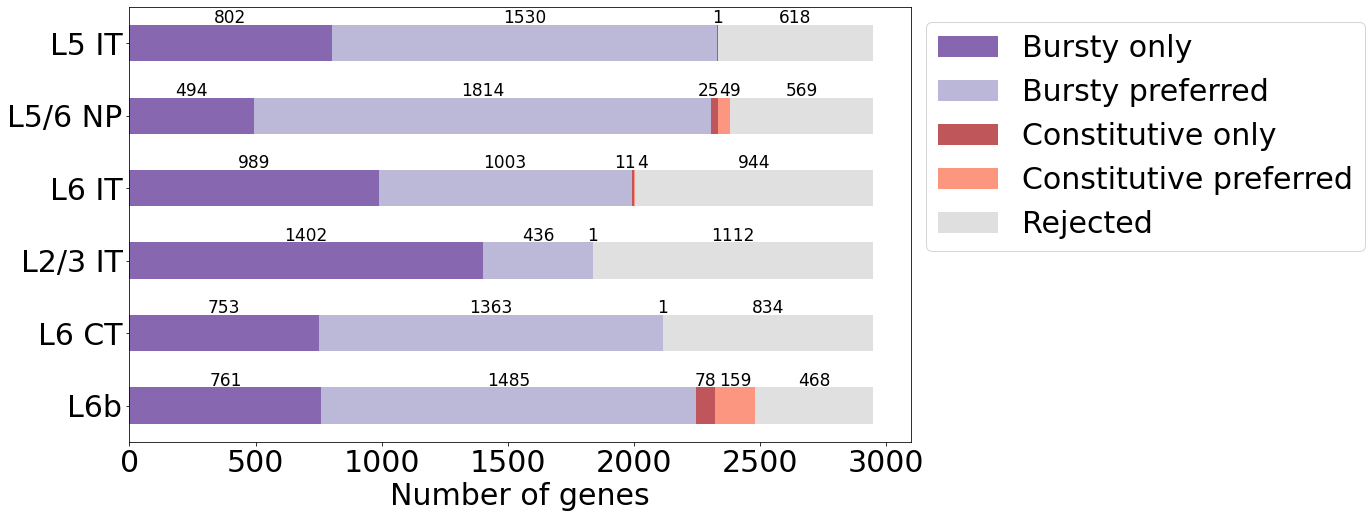

In [8]:
fs = 30
ls= 30
fig, ax = plt.subplots(figsize=(14,8))
num_df.plot(x = 'celltype', 
    kind = 'barh', 
    stacked = True, 
    ax = ax,
    mark_right = True,
    alpha = 0.7,
    color = colors_cb)

ax.set_ylabel('',fontsize=fs)
ax.tick_params(axis='both', labelsize=ls)
if norm == True:
    ax.set_xlabel('Percent of accepted genes exhibiting behavior',fontsize=fs)
if norm != True:
    ax.set_xlabel('Number of genes',fontsize=fs)


for c,container in enumerate(ax.containers):
    for b,bar in enumerate(container):
        width = bar.get_width()
        if width != 0:
            w = 0
            if (b == 4) and (c==2):
                w = -25
            if (b == 4) and (c==3):
                w = 25
            if (b == 3) and (c==2):
                w = -30
            if (b == 3) and (c==3):
                w = 30
            x = bar.get_x() + width / 2 + w
            y = bar.get_y() + bar.get_height() - 0.03
            label = f'{width:.0f}'
            ax.text(x, y, label, ha='center', va='bottom', fontsize=17)
        
plt.legend(bbox_to_anchor=(1.0,1.0),fontsize=fs);

# All models

In [9]:
color_dict

NameError: name 'color_dict' is not defined

In [18]:
models = ['Bursty','Constitutive','Extrinsic','Delay','DelayedSplicing']

b_list = np.zeros(len(samp_paths))
c_list = np.zeros(len(samp_paths))
co_list = np.zeros(len(samp_paths))
e_list = np.zeros(len(samp_paths))
eo_list = np.zeros(len(samp_paths))
d_list = np.zeros(len(samp_paths))
do_list = np.zeros(len(samp_paths))
ds_list = np.zeros(len(samp_paths))
dso_list = np.zeros(len(samp_paths))
rej_list = np.zeros(len(samp_paths))
ct_list = []


all_genes_reg = np.zeros((len(samp_paths),n_genes),dtype=object)*''


for s,samp in enumerate(samp_paths):
    samp_dict = pickle.load(open(f"{samp}","rb"))
    split = samp.split('_')
    ct_list.append(ct_map_dict[samp.split('_')[-1].split('.')[0]])
    assignments_samp = []
    
    # loop through all genes
    for g in range(n_genes): 
        
        # find models that were not rejected
        models_ = []
        AIC_vals_ = []
        
        for m in models:
            if samp_dict[m]['rejected_genes'][g] == False:
                models_.append(m)
                AIC_vals_.append(samp_dict[m]['AIC'][g])
        
        if len(models_)==0:
            assignments_samp.append('Rejected')
        else:
            # get AIC
            AIC_weights_ = get_AIC_weights_1g(np.array(AIC_vals_))
            assignment_ = models_[np.where(AIC_weights_ == max(AIC_weights_))[0][0]]
            assignments_samp.append(assignment_)
            
    assignments_samp = np.array(assignments_samp,dtype='object') 
    all_genes_reg[s] = assignments_samp
    
    b_list[s] = sum(assignments_samp=='Bursty')
    c_list[s] = sum(assignments_samp=='Constitutive')
    e_list[s] = sum(assignments_samp=='Extrinsic')
    d_list[s] = sum(assignments_samp=='Delay')
    ds_list[s] = sum(assignments_samp=='DelayedSplicing')
    rej_list[s] = sum(assignments_samp=='Rejected')

In [11]:
norm = False
separate = False

b_list = []
bo_list = []
c_list = []
co_list = []
e_list = []
eo_list = []
d_list = []
do_list = []
ds_list = []
dso_list = []
ct_list = []
reg_list = []

models = ['Bursty','Constitutive','Extrinsic','Delay','DelayedSplicing']
all_genes_reg = np.zeros((len(samp_paths),n_genes),dtype=object)*''

for s,samp in enumerate(samp_paths):
    samp_dict = pickle.load(open(f"{samp}","rb"))
    AIC_vals = []
    
    filt = np.full(n_genes, True)
    for model in models:
        filt_ = ~samp_dict[model]['rejected_genes']
        filt = filt & filt_
        if separate == True:
            tag = 'o'
        else:
            tag = '.'
        all_genes_reg[s,filt_] = np.array( [model+tag]*sum(filt_) , dtype=object)
    for model in models:
        AIC_vals.append(samp_dict[model]['AIC'][filt])
    
    AIC_weights = get_AIC_weights(AIC_vals)
    assignments = np.array([models[np.where( row == np.max(row))[0][0]] for row in AIC_weights.T])
    all_genes_reg[s,filt] = assignments 
    
    if norm == True:
        b_list.append( np.sum(all_genes_reg[s] == 'Bursty') / sum(filt))
        bo_list.append( np.sum(all_genes_reg[s] == 'Burstyo') / sum(filt))
        c_list.append( np.sum(all_genes_reg[s] == 'Constitutive') / sum(filt))
        co_list.append( np.sum(all_genes_reg[s] == 'Constitutiveo') / sum(filt))
        e_list.append( np.sum(all_genes_reg[s] == 'Extrinsic') / sum(filt))
        eo_list.append( np.sum(all_genes_reg[s] == 'Extrinsico') / sum(filt))
        d_list.append( np.sum(all_genes_reg[s] == 'Delay') / sum(filt))
        do_list.append( np.sum(all_genes_reg[s] == 'Delayo') / sum(filt))
        ds_list.append( np.sum(all_genes_reg[s] == 'DelayedSplicing') / sum(filt))
        dso_list.append( np.sum(all_genes_reg[s] == 'DelayedSplicingo') / sum(filt))
        reg_list.append( np.sum(all_genes_reg[s] == '') / sum(filt)) 
    else:
        b_list.append( np.sum(all_genes_reg[s] == 'Bursty') )
        bo_list.append( np.sum(all_genes_reg[s] == 'Burstyo') )
        c_list.append( np.sum(all_genes_reg[s] == 'Constitutive') )
        co_list.append( np.sum(all_genes_reg[s] == 'Constitutiveo') )
        e_list.append( np.sum(all_genes_reg[s] == 'Extrinsic') )
        eo_list.append( np.sum(all_genes_reg[s] == 'Extrinsico') )
        d_list.append( np.sum(all_genes_reg[s] == 'Delay') )
        do_list.append( np.sum(all_genes_reg[s] == 'Delayo') )
        ds_list.append( np.sum(all_genes_reg[s] == 'DelayedSplicing') )
        dso_list.append( np.sum(all_genes_reg[s] == 'DelayedSplicingo') )
        reg_list.append( np.sum(all_genes_reg[s] == '') )
    split = samp.split('_')
    ct_list.append(split[-1][:].split('.')[0])

    


In [21]:
separate = False

In [22]:
if separate == True:
    num_df_all = pd.DataFrame({'celltype' : ct_list,
                       'Bursty only': bo_list,
                       'Bursty preferred': b_list,
                       'Constitutive only' : co_list,
                       'Constitutive preferred' : c_list,
                       'Extrinsic only' : eo_list,
                       'Extrinsic preferred' : e_list,
                       'Delayed degradation only' : do_list,
                       'Delayed degradation preferred' : d_list,  
                       'Delayed splicing only' : dso_list,
                       'Delayed splicing preferred' : ds_list,
                       'Rejected' : rej_list})
    colors = colors_sep

else:
    num_df_all = pd.DataFrame({'celltype' : ct_list,
                       'Bursty': b_list,
                       'Constitutive' : c_list,
                       'Extrinsic' : e_list,
                       'Delay' : d_list,  
                       'Delayed splicing' : ds_list,
                       'Rejected' : rej_list
                              })
    colors = colors

In [23]:
num_df_all

,celltype,Bursty,Constitutive,Extrinsic,Delay,Delayed splicing,Rejected
0,L6b,1209.0,146.0,724.0,478.0,128.0,266.0
1,L6 CT,1288.0,0.0,602.0,282.0,2.0,777.0
2,L2/3 IT,1145.0,1.0,522.0,294.0,4.0,985.0
3,L6 IT,1226.0,5.0,636.0,292.0,5.0,787.0
4,L5/6 NP,1535.0,31.0,460.0,426.0,24.0,475.0
5,L5 IT,250.0,0.0,1160.0,962.0,0.0,579.0


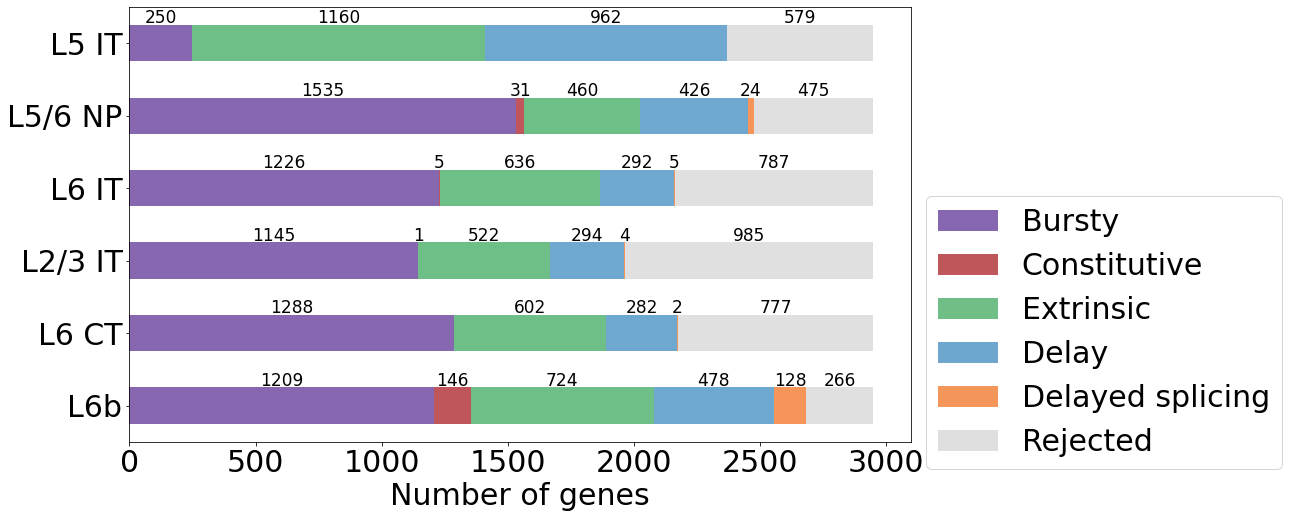

In [24]:
fs = 30
fig, ax = plt.subplots(figsize=(14,8))
num_df_all.plot(x = 'celltype', 
    kind = 'barh', 
    stacked = True, 
    ax = ax,
    mark_right = True,
    alpha = 0.7,
    color = colors)

ax.set_ylabel('',fontsize=fs)
ax.tick_params(axis='both', labelsize=ls)
if norm == True:
    ax.set_xlabel('Percent of accepted genes',fontsize=fs)
if norm != True:
    ax.set_xlabel('Number of genes',fontsize=fs)

for c,container in enumerate(ax.containers):
    for b,bar in enumerate(container):
        width = bar.get_width()
        if width != 0:
            x = bar.get_x() + width / 2 
            y = bar.get_y() + bar.get_height() - 0.03
            label = f'{width:.0f}'
            ax.text(x, y, label, ha='center', va='bottom', fontsize=17)
            
plt.legend(bbox_to_anchor=(1.0,.60),fontsize=fs);

In [1795]:
n_genes - num_df['Rejected'].values

array([2483, 2117, 1839, 2007, 2382, 2333])

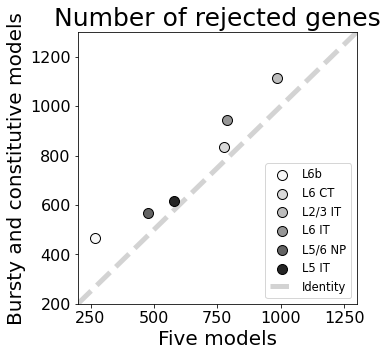

In [1968]:
fs = 20
ct_colors = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']
fig,ax = plt.subplots(figsize=(5,5))
for c,ct in enumerate(num_df['celltype']):
    plt.scatter(num_df_all['Rejected'].values[c],num_df['Rejected'].values[c],
                s=100,edgecolor='k',label=ct,color=ct_colors[c])
lims = [200,1300]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims,lims,linewidth=5.0,linestyle='--',c='lightgray',zorder=0,label='Identity')
plt.xlabel('Five models',fontsize=fs)
plt.ylabel('Bursty and constitutive models',fontsize=fs)
plt.title('Number of rejected genes',fontsize=25)
# plt.grid()
ax.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=11.5,loc='lower right');

----
## Upset plot

In [ ]:
# !pip install UpSetPlot

In [1799]:
from collections import defaultdict
import upsetplot


In [1800]:
# organize data for upset plot

modelreg_dict = defaultdict(int) # dictionary with 0 as default value
joined_reg = np.array(['.'.join(x) for x in zip(*all_genes_reg)])


for jr in joined_reg:

    jr_unique = np.unique(jr.split('.'))
    if '' in jr_unique:
        jr_unique = jr_unique[jr_unique!= '']
    jr_key = '.'.join(list(jr_unique))
    modelreg_dict[jr_key] += 1

In [1801]:
categories = list()
values = list()
for key in modelreg_dict.keys():
    if key != '':
        categories.append(key.split('.'))
        values.append(modelreg_dict[key])
    elif key == '':
        categories.append([])
        values.append(modelreg_dict[key])
    
upset_data = upsetplot.from_memberships(categories,data=values)

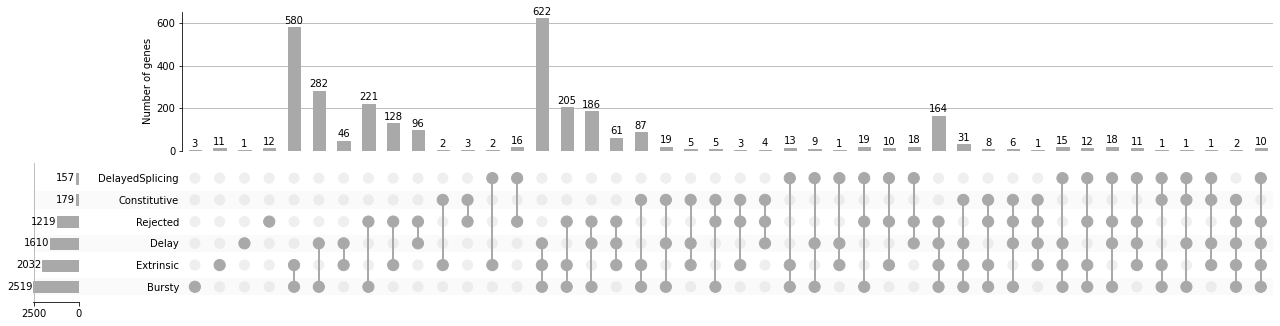

In [1802]:
plot_result = upsetplot.plot(upset_data,facecolor="darkgray",show_counts=True)
plot_result["intersections"].set_ylabel("Number of genes")
# plot_result["totals"].set_xlabel("Category size")
plt.show()

## Triangle plots

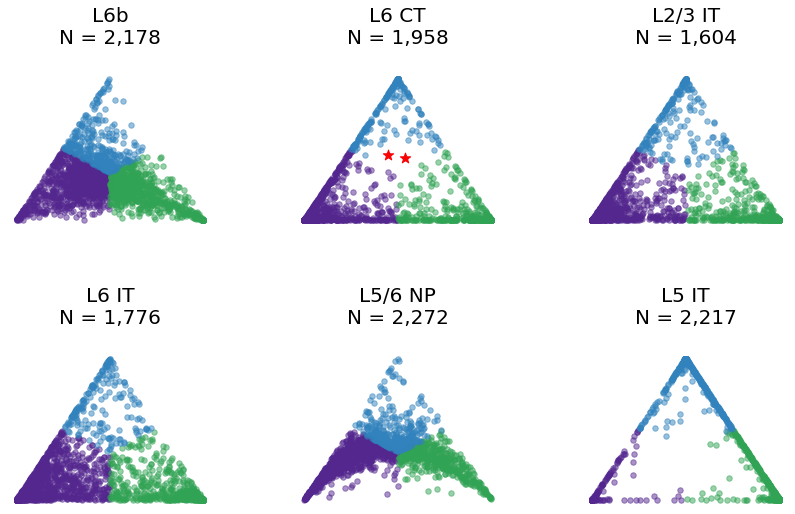

In [1953]:
separate = False
models =  ['Bursty',
           'Constitutive',
           'Extrinsic',
           'Delay',
           'DelayedSplicing']

size = 30
alpha = 0.5


fig,axs = plt.subplots(2,3,figsize = (14,8) )


for s,samp in enumerate(samp_paths):
    all_genes_reg = np.zeros((n_genes),dtype=object)*''
    ax1 = int(np.floor(s/3))
    ax2 = int(s%3)
    ax = axs[ax1,ax2]
    
    samp_dict = pickle.load(open(f"{samp}","rb"))
    split = samp.split('_')
    ct = ct_map_dict[samp.split('_')[-1].split('.')[0]]
    models_ = ['Bursty','Extrinsic','Delay']
#     print(models_)

    AIC_vals = []
    
    filt = np.full(n_genes, True)
    for model in models_:
        filt_ = ~samp_dict[model]['rejected_genes']
        filt = filt & filt_
        if separate == True:
            tag = '0'
        else:
            tag = ''
        all_genes_reg[filt_] = np.array( [model+tag]*sum(filt_) , dtype=object)
    for model in models_:
        AIC_vals.append(samp_dict[model]['AIC'][filt])
    
    AIC_weights = get_AIC_weights(AIC_vals)
    assignments = np.array([models_[np.where( row == np.max(row))[0][0]] for row in AIC_weights.T])
    all_genes_reg = assignments

    a = AIC_weights[0,:] # bursty
    b = AIC_weights[1,:] # ext
    c = AIC_weights[2,:] # delay

    x_bary = .5 * (2*b+c)/(a+b+c)
    y_bary = np.sqrt(3)/2*(c/(a+b+c))

#     # filters
#     filt_dict = {}
#     filt1 = (filt_list[0]&filt_list[1])|(filt_list[0]&filt_list[2])|(filt_list[1]&filt_list[2])
#     filt_dict[models_[0]] = filt_list[0]&(~filt_list[1])&(~filt_list[2])
#     filt_dict[models_[1]] = filt_list[1]&(~filt_list[0])&(~filt_list[2])
#     filt_dict[models_[2]] = filt_list[2]&(~filt_list[0])&(~filt_list[1])
                                   
                                   
    for i,m in enumerate(models_):
        ax.scatter(x_bary[all_genes_reg==m],
                   y_bary[all_genes_reg==m],
                   s=size,alpha=alpha,
                   color = color_dict[m])
    
    if 'L6CT' in samp:
        gene_names_ = samp_dict['Bursty']['gene_names'][filt]
        for g in ['Eprs','Ufd1']:
            ax.scatter(x_bary[gene_names_==g],y_bary[gene_names_==g],
                       color='red',marker='*',s=size*4)
        for g in ['Wipf2']:
            ax.scatter(x_bary[gene_names_==g],y_bary[gene_names_==g],
                       color='red',marker='*',s=size*4)
        
        
    ax.spines[['right', 'top','bottom','left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{ct}\nN = {sum(filt):,}\n ',fontsize=fs)
    ax.grid(True)
#     plt.show();

plt.subplots_adjust(wspace=.4, hspace=.8);
# plt.tight_layout();

----

# Gene histograms

In [1806]:
!ls results/al*

results/allen_B08_Glutamatergic.pickle	results/allen_B08_L6b.pickle
results/allen_B08_L23IT.pickle		results/allen_B08_L6CT.pickle
results/allen_B08_L56NP.pickle		results/allen_B08_L6IT.pickle
results/allen_B08_L5IT.pickle


In [1955]:
ct = 'allen_B08_L6CT'
samp = f'./results/{ct}.pickle'
samp_dict = pickle.load(open(f"{samp}","rb"))

In [1956]:
# load in search data objects
ct = 'allen_B08_L6CT'
bursty_path = f'./fits/mc_240521_026_allen_B08_1/{ct}/Bursty_Poisson_10x11'
sr_bursty = monod.analysis.load_search_results(f'{bursty_path}/grid_scan_results.res')
sr_bursty.find_sampling_optimum()
sd = monod.analysis.load_search_data(f'./fits/mc_240521_026_allen_B08_1/{ct}/raw.sd')

const_path = f'./fits/mc_240521_026_allen_B08_1/{ct}/Constitutive_Poisson_10x11'
sr_const = monod.analysis.load_search_results(f'{const_path}/grid_scan_results.res')
sr_const.find_sampling_optimum()

ext_path = f'./fits/mc_240521_026_allen_B08_1/{ct}/Extrinsic_Poisson_10x11'
sr_ext = monod.analysis.load_search_results(f'{ext_path}/grid_scan_results.res')
sr_ext.find_sampling_optimum()

delay_path = f'./fits/mc_240521_026_allen_B08_1/{ct}/Delay_Poisson_10x11'
sr_delay = monod.analysis.load_search_results(f'{delay_path}/grid_scan_results.res')
sr_delay.find_sampling_optimum();

delays_path = f'fits/mc_240521_029_allen_B08_1/{ct}/DelayedSplicing_Poisson_10x11'
sr_delays = monod.analysis.load_search_results(f'{delays_path}/grid_scan_results.res')
sr_delays.find_sampling_optimum();

samp_dict = pickle.load(open(f"./results/{ct}.pickle","rb"))
AIC_vals = []
filt = np.full(n_genes, True)


models_ = ['Bursty','Extrinsic','Delay']
for model in models_:
    filt = filt & ~samp_dict[model]['rejected_genes']
    print(sum(filt))
for model in models_:
    AIC_vals.append(samp_dict[model]['AIC'][filt])

AIC_weights = get_AIC_weights(AIC_vals)
assignments = np.array([models[np.where( row == np.max(row))[0][0]] for row in AIC_weights.T])

a = AIC_weights[0,:] # bursty
b = AIC_weights[1,:] # ext
c = AIC_weights[2,:] # delay

x_bary = .5 * (2*b+c)/(a+b+c)
y_bary = np.sqrt(3)/2*(c/(a+b+c))

2117
1995
1958


In [1957]:
bursty_only_genes = sd.gene_names [ ( ~samp_dict['Bursty']['rejected_genes']&\
      samp_dict['Extrinsic']['rejected_genes']&\
      samp_dict['Delay']['rejected_genes']) ]

ext_only_genes = sd.gene_names [ ( samp_dict['Bursty']['rejected_genes']&\
      ~samp_dict['Extrinsic']['rejected_genes']&\
      samp_dict['Delay']['rejected_genes']) ]

delay_only_genes = sd.gene_names [ ( samp_dict['Bursty']['rejected_genes']&\
      samp_dict['Extrinsic']['rejected_genes']&\
      ~samp_dict['Delay']['rejected_genes']) ]

In [1958]:
accepted_genes = sd.gene_names[filt]

bursty_genes = accepted_genes[ (x_bary < 0.01) & (y_bary < 0.01)] 
ext_genes = accepted_genes[ (x_bary > 0.99) & (y_bary < 0.01) ] 
delay_genes = accepted_genes[ y_bary > 0.8] 


bed_genes = accepted_genes[ (x_bary > 0.38) & (x_bary < 0.6) & (y_bary > 0.37) & (y_bary < 0.46) ]  
print(bed_genes)

['Eprs' 'Ufd1']


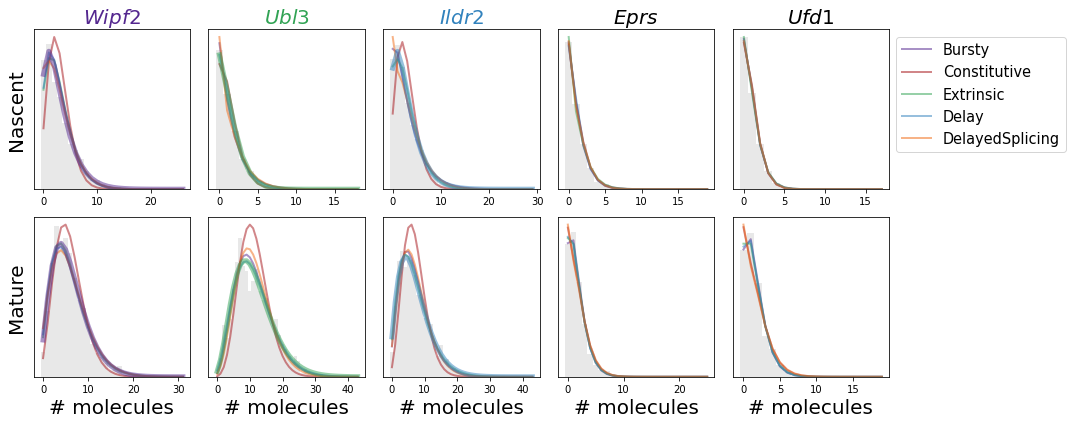

In [1967]:
# select genes for gene distribution plots
gene_names = np.random.choice(delay_only_genes,5)
gene_names = ['Wipf2','Ubl3','Ildr2','Eprs','Ufd1']
fs = 20
eps = 1e-18
alpha = 0.5
linewidth=2.0

fig,ax1 = plt.subplots(2,5,figsize = (15,6))

search_result_list = [sr_bursty,sr_const,sr_ext,sr_delay,sr_delays]
models = ['Bursty','Constitutive','Extrinsic','Delay','DelayedSplicing']
z_order = [0,2,3,12,12]
hist_colors = ['#54278f','#31a354','#3182bd','k','k']


for g,gene_name in enumerate(gene_names):
    
    i_ = np.where(sd.gene_names == gene_name)[0][0]
    lm = np.copy(sd.M[:, i_])
    
    # plot gene histograms
    mx_nas = int(sd.layers[0, i_,:].max()+10)
    nas_bins = np.arange(mx_nas -8)-0.5
    mx_mat = int(sd.layers[1, i_,:].max()+10)
    mat_bins = np.arange(mx_mat -8)-0.5
    ax1[0,g].hist(sd.layers[0, i_,:] , bins = nas_bins, color='lightgray', alpha=alpha,density=True)
    ax1[1,g].hist(sd.layers[1, i_,:] , bins = mat_bins, color='lightgray', alpha=alpha,density=True)
    
    for s,sr_ in enumerate(search_result_list):
        model = models[s]
        samp = sr_.regressor_optimum[i_]
        Pa_ = np.squeeze(sr_.model.eval_model_pss(sr_.phys_optimum[i_], lm, samp))
    
        if s == z_order[g]:
            z_ = 3
            linewidth = 5.0
        else:
            z_ = 1
            linewidth = 2.0
            
        ax1[0,g].plot(Pa_.sum(axis=1), color = color_dict[model], label = model,
                      alpha = alpha, linewidth = linewidth, zorder = z_)
        ax1[0,g].set_yticks([])
        ax1[1,g].plot(Pa_.sum(axis=0), color = color_dict[model], label = model,
                      alpha = alpha, linewidth = linewidth, zorder = z_)
        ax1[0,g].set_title(f'${gene_name}$',fontsize=fs,color=hist_colors[g])
        ax1[1,g].set_xlabel("# molecules",fontsize=fs)
        ax1[1,g].set_yticks([])

ax1[0,0].set_ylabel("Nascent",fontsize=fs)
ax1[1,0].set_ylabel("Mature",fontsize=fs)
ax1[0,-1].legend(fontsize=14.5,bbox_to_anchor=(1.0,1.0))
plt.tight_layout();

# Number of cells per celltype

In [1886]:
num_cells_per_ct = []

# load in search data objects
for ct_ in ct_list:
    
    bursty_path = f'./fits/mc_240521_026_allen_B08_1/allen_B08_{ct_}/Bursty_Poisson_10x11'
    sr_bursty = monod.analysis.load_search_results(f'{bursty_path}/grid_scan_results.res')
    num_cells_per_ct.append(sr_bursty.n_cells)

In [1887]:
num_per_ct = pd.DataFrame({
    'celltype' : ct_list,
    'Number of cells' : num_cells_per_ct
})

,celltype,Number of cells
0,L6b,66
1,L6CT,1333
2,L23IT,823
3,L6IT,489
4,L56NP,250
5,L5IT,2382


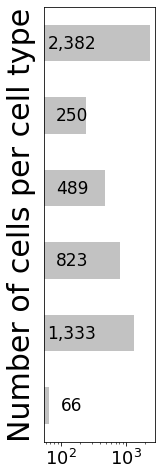

In [1943]:
fs = 30
fig, ax = plt.subplots(figsize=(2,8))
num_per_ct.plot(x = 'celltype', 
    kind = 'barh', 
    stacked = True, 
    ax = ax,
    mark_right = True,
    alpha = 0.7,
    color = 'darkgray',
    legend=False)
plt.yticks([])
plt.ylabel('Number of cells per cell type',fontsize=fs)
# plt.xlim(0,3100)
plt.xscale('log')


ax.tick_params(axis='both', labelsize=18)
for c,container in enumerate(ax.containers):
    for b,bar in enumerate(container):
        width = bar.get_width()
        if width != 0:
#             x = bar.get_x() + width /2
            x = 150
            y = bar.get_y() + bar.get_height() / 2 - 0.13
            label = f'{width:,.0f}'
            ax.text(x, y, label, ha='center', va='bottom', fontsize=17)
            
            
            

# New AIC comparison ideas


This for genes across cell types.


I am first constructing a matrix which is models by genes by cell type with AIC weights. Where models were rejected, the AIC weight will be 0. I can always remove the genes that have 0 values in ALL cell types. 

In [2002]:
models = ['Bursty','Constitutive','Extrinsic','Delay','DelayedSplicing']

AIC_array = np.zeros((5,2951,6))    # model by number of genes by number of cell types


AIC_vals = []


for s,samp in enumerate(samp_paths):
    samp_dict = pickle.load(open(f"{samp}","rb"))
    split = samp.split('_')
    
    # loop through all genes
    for g in range(n_genes): 
        
        # find models that were not rejected
        models_ = []
        AIC_vals_ = []
        
        for m in models:
            if samp_dict[m]['rejected_genes'][g] == False:
                models_.append(m)
                AIC_vals_.append(samp_dict[m]['AIC'][g])
        
        if len(models_)==0:
            null_ = 0
        else:
            # get AIC
            model_filt = [m in models_ for m in models]
            AIC_weights_ = get_AIC_weights_1g(np.array(AIC_vals_))
            AIC_array[model_filt,g,s] = AIC_weights_


First, plotting variance vs. mean of AIC weights for all models.

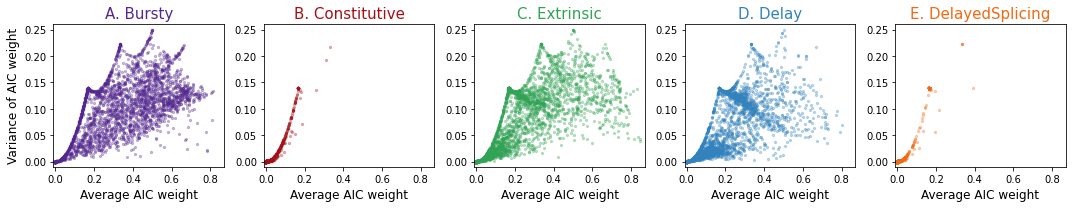

In [2062]:
fs2 = 12

fig,ax = plt.subplots(1,5,figsize=(15,3))

letters = ['A','B','C','D','E']
for m,model_ in enumerate(models):
    mean_ = np.mean(AIC_array[m],axis=1)
    variance_ = np.var(AIC_array[m],axis=1)
     
    ax[m].scatter(mean_,variance_,
                  color = color_dict[model_],
                  s = 5,
                  alpha = 0.3)
    
    
    ax[m].set_xlim(-0.01,0.87)
    ax[m].set_ylim(-0.01,0.26)
    ax[m].set_xlabel('Average AIC weight',fontsize=fs2)
    ax[m].set_title(letters[m]+'. '+model_,color=color_dict[model_],fontsize=fs2+3)
    
ax[0].set_ylabel('Variance of AIC weight',fontsize=fs2)
    
plt.tight_layout();

Now, try plotting mean and variance of variance of AIC weights across cell types.

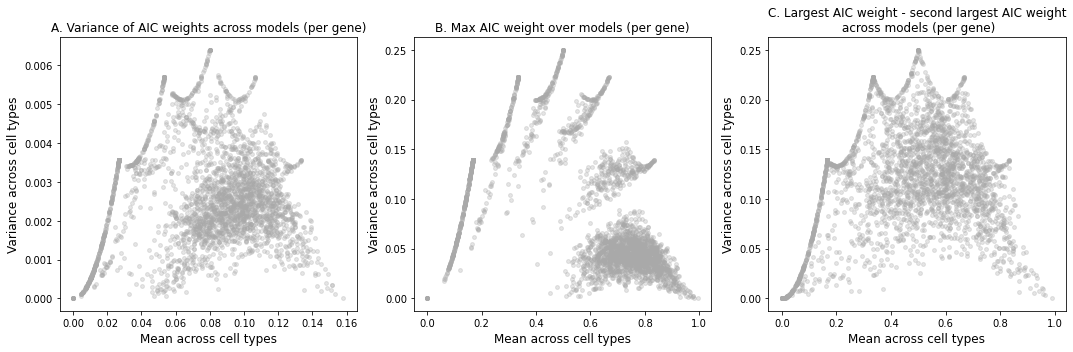

In [2113]:
fs2 = 12
s = 15
alpha = 0.3


fig,ax = plt.subplots(1,3,figsize=(15,5))

AIC_ct_variances = np.var(AIC_array,axis=0)
mean_ = np.mean(AIC_ct_variances,axis=1)
variance_ = np.var(AIC_ct_variances,axis=1)

ax[0].scatter(mean_,variance_,
           color = 'darkgray',
           s = s,
           alpha = alpha)
ax[0].set_title('A. Variance of AIC weights across models (per gene)')

AIC_max = np.amax(AIC_array,axis=0)
mean_ = np.mean(AIC_max,axis=1)
variance_ = np.var(AIC_max,axis=1)

ax[1].scatter(mean_,variance_,
           color = 'darkgray',
           s = s,
           alpha = alpha)
ax[1].set_title('B. Max AIC weight over models (per gene)')
# ax[1].axvline(1/6,color='darkred',linestyle='--',linewidth=3.0,alpha=0.7,
#              label='Equally likely')


# get percent change of highest/next highes AIC weight
sorted_AIC = np.sort(AIC_array, axis=0)
AIC_second_largest = np.take(sorted_AIC, -2, axis=0)

AIC_percent_diff = AIC_max - AIC_second_largest
mean_ = np.mean(AIC_percent_diff,axis=1)
variance_ = np.var(AIC_percent_diff,axis=1)

ax[2].scatter(mean_,variance_,
           color = 'darkgray',
           s = s,
           alpha = alpha)
ax[2].set_title('C. Largest AIC weight - second largest AIC weight\n across models (per gene)')

    
    
for i in range(3):
    ax[i].set_xlabel('Mean across cell types',fontsize=fs2)
    ax[i].set_ylabel('Variance across cell types',fontsize=fs2)

    
    
plt.tight_layout();

If we want to only compare genes that were fit by at least one model in ALL cell types. Yeah, let me try.

In [2109]:
filt = AIC_array.sum(axis=0)>0
filt = np.sum(filt,axis=1) == 6 

AIC_array_subset = AIC_array[:,filt,:]

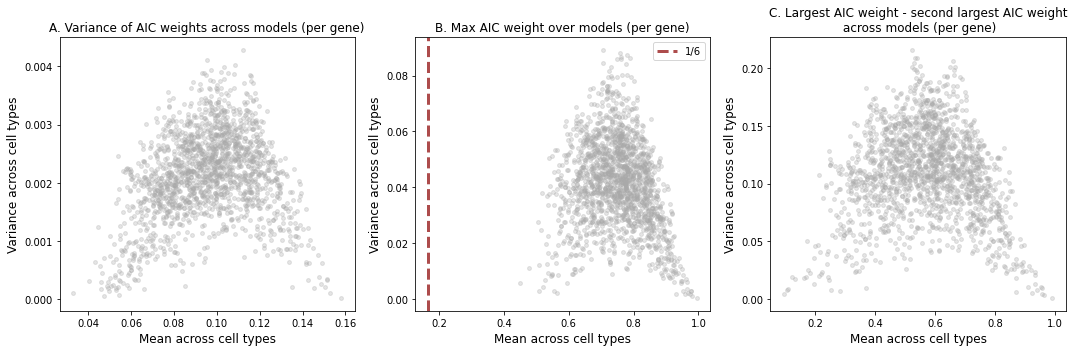

In [2114]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

AIC_ct_variances = np.var(AIC_array_subset,axis=0)
mean_ = np.mean(AIC_ct_variances,axis=1)
variance_ = np.var(AIC_ct_variances,axis=1)

ax[0].scatter(mean_,variance_,
           color = 'darkgray',
           s = s,
           alpha = alpha)
ax[0].set_title('A. Variance of AIC weights across models (per gene)')

AIC_max = np.amax(AIC_array_subset,axis=0)
mean_ = np.mean(AIC_max,axis=1)
variance_ = np.var(AIC_max,axis=1)

ax[1].scatter(mean_,variance_,
           color = 'darkgray',
           s = s,
           alpha = alpha)
ax[1].set_title('B. Max AIC weight over models (per gene)')
ax[1].axvline(1/6,color='darkred',linestyle='--',linewidth=3.0,alpha=0.7,label='1/6')
ax[1].legend()


# get percent change of highest/next highes AIC weight
sorted_AIC = np.sort(AIC_array_subset, axis=0)
AIC_second_largest = np.take(sorted_AIC, -2, axis=0)

AIC_percent_diff = AIC_max - AIC_second_largest
mean_ = np.mean(AIC_percent_diff,axis=1)
variance_ = np.var(AIC_percent_diff,axis=1)

ax[2].scatter(mean_,variance_,
           color = 'darkgray',
           s = s,
           alpha = alpha)
ax[2].set_title('C. Largest AIC weight - second largest AIC weight\n across models (per gene)')

    
    
for i in range(3):
    ax[i].set_xlabel('Mean across cell types',fontsize=fs2)
    ax[i].set_ylabel('Variance across cell types',fontsize=fs2)

    
    
plt.tight_layout();